In [37]:
import pandas as pd, matplotlib.pyplot as plt, re, os, itertools, collections, tqdm, textwrap, numpy as np, os
from matplotlib import rcParams
rcParams['font.family'] = ["P052", "Fira Code"]
%config InlineBackend.figure_format = 'svg'

In [7]:
# See how many sites PSP and atlas have in common from the files /Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/site_list_86201.txt and /Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/PSP_site_list.csv

# Read in the site list from the atlas
site_list_atlas = pd.read_csv('/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/site_list_86201.txt', header=None).values[:,0].tolist()
site_list_psp = sorted([x.upper() for x in pd.read_excel('/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/raw_data/PSP_script_download.xlsx')['SITE_+/-7_AA'].values.tolist()])


/Users/druc594/miniforge3/envs/py311/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


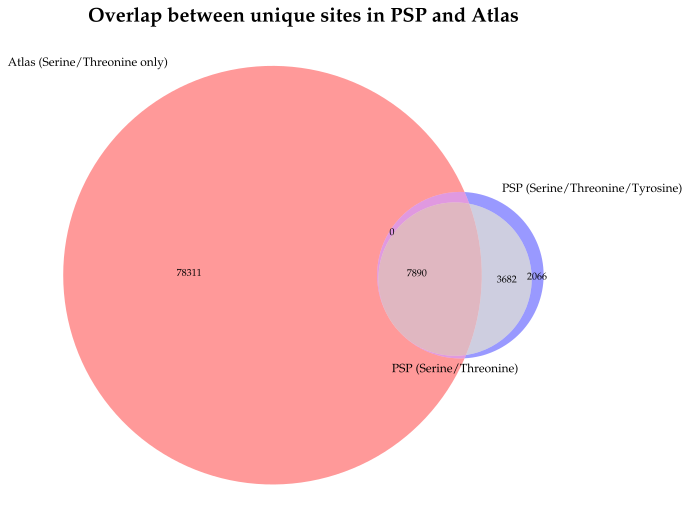

In [39]:
# Create a Venn diagram from the two lists
fig = plt.figure(figsize=(10,10))
from matplotlib_venn import venn3
serine_or_threonine = {'S', 'T'}
venn3([set(site_list_atlas), set(site_list_psp), set([x for x in site_list_psp if x[7] in serine_or_threonine])], set_labels = ('Atlas (Serine/Threonine only)', 'PSP (Serine/Threonine/Tyrosine)', 'PSP (Serine/Threonine)'), set_colors=('r', 'b', 'y'))
plt.title(tt := "Overlap between unique sites in PSP and Atlas", fontsize=20, fontweight='bold')
plt.savefig(os.path.expanduser(f"~/Desktop/{tt}.pdf"), bbox_inches='tight')

In [18]:
len([x for x in sorted(list(set(site_list_psp))) if x[7] in serine_or_threonine])

11572

In [28]:
site_list_psp

['AAAAKKGSEQESVKE',
 'AAAAKKGSEQESVKE',
 'AAAFPTASPANKDVS',
 'AAAGGQGSAVAAEAE',
 'AAAGPALSPVPPVVH',
 'AAAGPALSPVPPVVH',
 'AAAGPALSPVPPVVH',
 'AAAGPALSPVPPVVH',
 'AAAGPALSPVPPVVH',
 'AAAGPALSPVPPVVH',
 'AAAGPKASPTPQKTS',
 'AAAGSGPSPPCSPGH',
 'AAAGYGRSPGSLSLH',
 'AAAHRKGSSSNEPSS',
 'AAAHRKGSSSNEPSS',
 'AAAHRKGSSSNEPSS',
 'AAAHRKGSSSNEPSS',
 'AAAHRKGSSSNEPSS',
 'AAAKIQASFRGHMAR',
 'AAAKIQASFRGHMAR',
 'AAAKIQASFRGHMAR',
 'AAAKIQASFRGHMAR',
 'AAASLPSSKEVAELK',
 'AAASQQGSAKNGENT',
 'AAAVQQHSASQQHSA',
 'AAAVRPFTPQPSKDT',
 'AADEEPDSPTEALQT',
 'AADSGRGSWTSCSSG',
 'AAEAAPPTQEAQGET',
 'AAEEEDESILDTVIK',
 'AAEERRKSHEAEVLK',
 'AAEERRKSHEAEVLK',
 'AAEERRKSHEAEVLK',
 'AAEERRKSHEAEVLK',
 'AAEERRKSHEAEVLK',
 'AAEERRKSHEAEVLK',
 'AAEFRKKSGSAPPRK',
 'AAEGKRHTLTVRDAS',
 'AAEGRRKSQEAQVLK',
 'AAEGRRKSQEAQVLK',
 'AAERPGGTPTPVIAY',
 'AAFRLFKYGVQLYKN',
 'AAGARPLTSPESLSR',
 'AAGGTRGSNHARIDA',
 'AAGTQQPYTDGVRME',
 'AAGTQQPYTDGVRME',
 'AAHDTEATATDYHTT',
 'AAHGKRPSIGDLEHV',
 'AAIPINGSPRTPRRG',
 'AAIPINGSPRTPRRG',


##### Since there is no overlap, we have to scrape from the Nature Atlas

In [ ]:
### Assume we have already run scrape.py

# Open all files in scraped directory and create a mapping from site name to results table
scraped_path = '/Users/druc594/Downloads/KinLibDown'
mapping = {}
for file in [x for x in os.listdir(scraped_path) if x.endswith('.tsv')]:
    site_name = ""
    tab = None
    try:
        tab = pd.read_csv(os.path.join(scraped_path, file), sep='\t')
        site_name = re.sub(r'-[0-9]+`[0-9]+\.tsv', '', file)
    except Exception as e:
        print(e)
        print("Problem:", file)
    
    mapping[site_name] = tab

for k, v in mapping.items():
    mapping[k] = v.set_index("kinase").to_dict()['site_percentile']
THEIR_RESULTS_FILE = "./41586_2022_5575_MOESM5_ESM.csv"
their_results = pd.read_csv(THEIR_RESULTS_FILE).set_index("Uniprot Primary Accession")
matrix_name_to_uniprot_id: dict[str, str] = (
    pd.read_csv("./41586_2022_5575_MOESM3_ESM.csv").set_index("Matrix_name").to_dict()["Uniprot id"]
)


### "Target" Histogram

In [ ]:

uniprot_id_to_matrix_name = {v: k for k, v in matrix_name_to_uniprot_id.items()}
assert len(uniprot_id_to_matrix_name) == len(matrix_name_to_uniprot_id)
kin_uniprot_to_sites = collections.defaultdict(list[str])
psp = pd.read_excel("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/raw_data/PSP_script_download.xlsx")[["SITE_+/-7_AA", "KIN_ACC_ID"]]


for _, row in psp.iterrows():
    assert isinstance(row["SITE_+/-7_AA"], str)
    kin_uniprot_to_sites[row["KIN_ACC_ID"]].append(re.sub(r"^(.{8})", r"\1*", row["SITE_+/-7_AA"].upper()))
mod_cols = set([matrix_name_to_uniprot_id[re.sub(r"^([0-9A-Z]+)_rank.*", r"\1", x)] for x in their_results.columns if x.endswith("_rank")])
kuts = kin_uniprot_to_sites.copy().keys()


for kin_u in kuts:
    if kin_u not in mod_cols:
        kin_uniprot_to_sites.pop(kin_u)
site_to_kin_uniprots = collections.defaultdict(list[str])


for kin_u, sites in kin_uniprot_to_sites.items():
    for site in sites:
        site_to_kin_uniprots[site].append(kin_u)


site_to_kin_uniprots_shortened = {k.replace("*", "")[2:-1].replace("_", ""):v for k,v in site_to_kin_uniprots.items()}
site_to_percentiles = collections.defaultdict(list[float])


# Build up a mapping from site to list of percentiles
for site in mapping:
    assert site in site_to_kin_uniprots_shortened, f"{site} not in site_to_kin_uniprots_shortened"
    for kin in site_to_kin_uniprots_shortened[site]:
        assert kin in uniprot_id_to_matrix_name, f"{kin} not in uniprot_id_to_matrix_name"
        assert site in mapping, f"{site} not in mapping"
        if uniprot_id_to_matrix_name[kin] in mapping[site]:
            site_to_percentiles[site].append(mapping[site][uniprot_id_to_matrix_name[kin]])
            
all_percentiles = list(itertools.chain(*site_to_percentiles.values()))

### "Decoy" Histogram

In [ ]:
# Load formatted data file
formatted_data = pd.read_csv('../../data/raw_data_45176_formatted_65.csv')
formatted_data['Site Sequence'] = formatted_data['Site Sequence'].apply(lambda x: x[2:-1])
our_kinase_name_to_uniprot = {x.split("|")[0]: x.split("|")[1] for x in formatted_data['Original Kinase Gene Name']}

# Extract just the entries where both the site is in the 150-site sample and it is a decoy
formatted_data = formatted_data[formatted_data['Site Sequence'].isin(site_to_percentiles.keys()) & (formatted_data['Class'] == 0)]

# Create a dictionary `decoy_kinases` from site to decoy kinase
decoy_kinases = formatted_data.set_index('Site Sequence').to_dict()['Original Kinase Gene Name (Possibly Deranged)']

# Build up `all_percentiles_decoy` by including `mapping[site][kinase]` for each kinase in `decoy_kinases`
all_percentiles_decoy = []
for site, kinase in decoy_kinases.items():
    ms = {k.upper(): v for k, v in mapping[site].items()}
    okntuk = our_kinase_name_to_uniprot[kinase]
    if okntuk in uniprot_id_to_matrix_name:
        uitmnokntuk = uniprot_id_to_matrix_name[okntuk]
    else:
        # print(f"Could not find {okntuk} in uniprot_id_to_matrix_name")
        continue
    all_percentiles_decoy.append(ms[uitmnokntuk])

assert len(site_to_percentiles)//2 < len(all_percentiles_decoy) <= len(site_to_percentiles), f"{len(all_percentiles_decoy)=}; {len(site_to_percentiles)=}"

#### Make a histogram of the percentiles (Target)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
max_height = 0
hist_data = ax.hist(all_percentiles, bins=list(range(0, 101, 5)))
this_max_height = max(hist_data[0])
assert isinstance(this_max_height, float)
max_height = max(max_height, this_max_height)
max_height = np.ceil(max_height / 5) * 5
fig.suptitle(
    textwrap.fill(
        (
            f"Distribution of Atlas-predicted percentiles for {len(all_percentiles)} experimentally validated PSP K-S"
            " pairs."
        ),
        60,
    ),
    fontsize=18,
    fontweight='bold',
    y=1.05
)
ax.set_title(textwrap.fill(f"{len(mapping)} sites scored by atlas; PSP contains an average of {len(all_percentiles)/len(mapping):.2f} kinases per site. {len(all_percentiles)/len(mapping):.2f} avg sites/kinase × {len(mapping)} kinases = {len(all_percentiles)} total sites", width=80), y=1)
ax.set_xlabel("Score Percentile")
ax.set_ylabel("Count")
ax.set_xticks(range(0, 101, 10), range(0, 101, 10))
ax.set_ylim(0, ylm := min(4 + max_height, max_height * 1.1))
ytk = range(0, int(max_height) + 1, max(1, int(5*np.floor(np.log10(max_height - 1)))))
ax.set_yticks(ytk, ytk)
for pctl in [25, 50, 75]:
    linewidth = 2 if pctl == 50 else 1
    linestyle = "-" if pctl == 50 else "--"
    ax.vlines(np.percentile(all_percentiles, pctl), 0, ylm, color="red", label=f"Distribution {pctl}th Percentile", linestyle=linestyle, linewidth=linewidth, alpha = 0.6)

ax.legend()
_ = ax.grid(visible=True, axis="y", linestyle="--", alpha=0.4)

### Make a histogram of the percentiles (Decoy)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
max_height = 0
hist_data = ax.hist(all_percentiles_decoy, bins=list(range(0, 101, 5)), label="Distribution")
this_max_height = max(hist_data[0])
assert isinstance(this_max_height, float)
max_height = max(max_height, this_max_height)
max_height = np.ceil(max_height / 5) * 5
fig.suptitle(
    textwrap.fill(
        (
            f"Distribution of Atlas-predicted percentiles for {len(all_percentiles_decoy)} derangement-generated false \"Decoy\" K-S"
            " pairs."
        ),
        60,
        replace_whitespace=False
    ),
    fontsize=18,
    fontweight='bold',
    y=1.1
)
ax.set_title(textwrap.fill(f"{len(mapping)} sites scored by atlas; PSP contains an average of {len(all_percentiles_decoy)/len(mapping):.2f} decoy-assigned kinases per site (that have an associated atlas score). {len(all_percentiles_decoy)/len(mapping):.2f} avg sites/kinase × {len(mapping)} kinases = {len(all_percentiles_decoy)} total sites", width=80), y=1)
ax.set_xlabel("Score Percentile")
ax.set_ylabel("Count")
ax.set_xticks(range(0, 101, 10), range(0, 101, 10))
ax.set_ylim(0, ylm := min(4 + max_height, max_height * 1.1))
ytk = range(0, int(max_height) + 1, max(1, int(5*np.floor(np.log10(max_height - 1)))))
ax.set_yticks(ytk, ytk)
for pctl in [25, 50, 75]:
    linewidth = 2 if pctl == 50 else 1
    linestyle = "-" if pctl == 50 else "--"
    ax.vlines(np.percentile(all_percentiles_decoy, pctl), 0, ylm, color="red", label=f"Distribution {pctl}th Percentile", linestyle=linestyle, linewidth=linewidth, alpha = 0.6)

ax.legend()
_ = ax.grid(visible=True, axis="y", linestyle="--", alpha=0.4)

#### Make a boxplot of the percentiles

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 7))
max_height = 0
ax.boxplot(all_percentiles)
# this_max_height = max(hist_data[0])
# assert isinstance(this_max_height, float)
# max_height = max(max_height, this_max_height)
# max_height = np.ceil(max_height/5) * 5
ax.set_title(textwrap.fill(f"Distribution of Atlas-predicted percentiles for {len(all_percentiles)} experimentally validated PSP K-S pairs", 40))
# ax.set_xlabel("Percentile")
ax.set_ylabel("Percentile")
ax.set_xticks([1], [f"{len(all_percentiles)} pairs"])
# ax.set_xticks(range(0, 101, 10), range(0, 101, 10))
# ax.set_ylim(0, min(4 + max_height, max_height*1.1))
# print(max_height)
_ = ax.set_yticks(range(0, 101, 10))
ax.grid(visible=True, axis = 'y', linestyle="--", alpha=0.4)

In [4]:
### Assume we have already run scrape.py

# Open all files in scraped directory and create a mapping from site name to results table
scraped_path = '/Users/druc594/Downloads/HIPK2-sites'
mapping = {}
for file in [x for x in os.listdir(scraped_path) if x.endswith('.tsv')]:
    site_name = ""
    tab = None
    try:
        tab = pd.read_csv(os.path.join(scraped_path, file), sep='\t')
        site_name = re.sub(r'-[0-9]+`[0-9]+\.tsv', '', file)
    except Exception as e:
        print(e)
        print("Problem:", file)
    
    mapping[site_name] = tab

for k, v in mapping.items():
    mapping[k] = v.set_index("kinase").to_dict()['site_percentile']
THEIR_RESULTS_FILE = "./41586_2022_5575_MOESM5_ESM.csv"
their_results = pd.read_csv(THEIR_RESULTS_FILE).set_index("Uniprot Primary Accession")
matrix_name_to_uniprot_id: dict[str, str] = (
    pd.read_csv("./41586_2022_5575_MOESM3_ESM.csv").set_index("Matrix_name").to_dict()["Uniprot id"]
)


In [8]:
what_they_say_about_HIPK2 = {s: mapping[s]['HIPK2'] for s in mapping}

(array([ 1.,  1.,  1.,  0.,  3.,  4.,  3., 15., 17., 19.]),
 array([ 6.36610866, 15.70085212, 25.03559558, 34.37033903, 43.70508249,
        53.03982595, 62.37456941, 71.70931287, 81.04405632, 90.37879978,
        99.71354324]),
 <BarContainer object of 10 artists>)

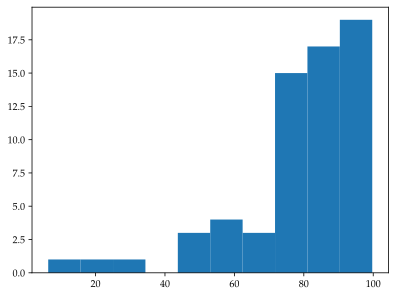

In [11]:
plt.hist(what_they_say_about_HIPK2.values())